# Features comparison

This notebook discusses predictions made using some different feature- and target combinations. The models used (*A*, *B*, *C*, *D* and *E*) are as described in the thesis. A quick summary:
- **Model A** uses three temperatures and process flow rate to predict outlet cooling temperature
- **Model B** uses three temperatures, process flow rate and coolant valve opening to predict outlet cooling temperature
- **Model C** uses three temperatures, process flow rate and coolant flow rate to predict outlet cooling temperature
- **Model D** uses three temperatures, process flow rate, coolant valve opening and coolant inlet pressure to predict outlet cooling temperature
- **Model E** uses three temperatures, process flow rate, coolant valve opening, coolant flow rate and coolant inlet pressure to predict outlet cooling temperature

Additionally, the process side pressure drop is included as a predicted (target) column whenever this is present in the dataset, which is the case for dataset *D* and *G*.

The stateful high-level API is used with some additional methods. Once more, the functionality of this notebook exceeds the primary intents for the high-level API, and thus does not follow the same recipe as the *basic examples*. Understanding the implemented python methods is not required in order to interpret the results, and therefore the implementation is not discussed in detail.

## Step 0: Import modules

In [1]:
# %load features_comparison.py
import src.core as mlApi
from src.utils.plots import (plotModelPredictions, plotModelScores, getPlotColors)
from src.utils.prints import (printModelScores)
import matplotlib.pyplot as plt
import src.core_configs as configs

colors = getPlotColors()
models = ['A', 'B', 'C', 'D', 'E']

Using TensorFlow backend.


## Step 1: Implement required methods

A method is implemented to perform the feature comparison. It takes as input a complete dataset configuration, including a list of irrelevant columns configurations that define each model. The provided column configurations are looped and predictions are gathered for each configuration. It is recommended to use only one machine learning model type (e.g. MLP/LSTM/Linear) at each time in order to achieve readable output plots. Predictions and metrics are gathered for each loop and eventually ploted/printed.

In [2]:
def featureComparison(
	irrelevantColumnsList,
	filename,
	columns,
	traintime,
	testtime,
	targetColumns,
	enrolWindow,
	):
	global colors, models

	columnsLists = []
	deviationsLists= []
	names = []
	trainmetrics = []
	testmetrics = []

	for i, irrelevantColumns in enumerate(irrelevantColumnsList):
		mlApi.reset()

		df = mlApi.initDataframe(filename, columns, irrelevantColumns)
		df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
		X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)
		
		linear_model = mlApi.Linear_Regularized("Linear " + models[i])
		mlp_model = mlApi.MLP("MLPd " + models[i], layers=[64, 64], dropout=0.2, epochs=2000)
		lstm_model = mlApi.LSTM("LSTMd " + models[i], layers=[64, 64], dropout=0.2, recurrentDropout=0.2, epochs=500, enrolWindow=enrolWindow)

		modelList = [
			#linear_model,
			mlp_model,
			#lstm_model,
		]

		mlApi.initModels(modelList)
		retrain=False
		mlApi.trainModels(retrain)

		modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(plot=True, score=False)

		if i < 1:
			columnsLists = columnsList
			deviationsLists = deviationsList
			all_names = modelNames
			all_train_metrics = metrics_train
			all_test_metrics = metrics_test
		else:
			for j_target in range(len(columnsList)):
				for k_model in range(1, len(columnsList[j_target])):
					columnsLists[j_target].append(columnsList[j_target][k_model])
				for k_model in range(0, len(deviationsList[j_target])):
					deviationsLists[j_target].append(deviationsList[j_target][k_model])
			all_names = [*all_names, *modelNames]
			all_train_metrics = [*all_train_metrics, *metrics_train]
			all_test_metrics = [*all_test_metrics, *metrics_test]

		names.append(modelNames)
		trainmetrics.append(metrics_train)
		testmetrics.append(metrics_test)

	indexColumn = mlApi._indexColumn
	columnDescriptions = mlApi._columnDescriptions
	columnUnits = mlApi._columnUnits
	traintime = mlApi._traintime

	for i in range(len(deviationsLists)):
		for j in range(len(deviationsLists[i])):
			deviationsLists[i][j][3] = colors[j]

	for i in range(len(columnsLists)):
		columnsList[i][0][3] = 'red'
		for j in range(1, len(columnsLists[i])):
			columnsLists[i][j][3] = colors[j-1]

	printModelScores(
		all_names,
		all_train_metrics,
		all_test_metrics,
	)
	plotModelPredictions(
		plt,
		deviationsLists,
		columnsLists,
		indexColumn,
		columnDescriptions,
		columnUnits,
		traintime,
		interpol=False,
	)
	plotModelScores(
		plt,
		all_names,
		all_train_metrics,
		all_test_metrics,
	)

## Step 2: Define configurations

### Configurations dataset D

In [3]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('D', None, '30min')
targetColumns = [
	'50TT002',
	'20PDT001',
]
irrelevantColumnsList = [
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50TV001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C flow
	[
		'20PT001',
		'50PDT001',
		'50TV001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'20PT001',
		'50PDT001',
	],
]

## Step 3: Make predictions

Configurations and predictions are made separately for each dataset, in order to increase readability and explainability of output. Even so, the output sequence is quite long, so detailed explainations are provided following each dataset output.

### Predictions dataset D

Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50TT002 - Cooling side outlet temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model 

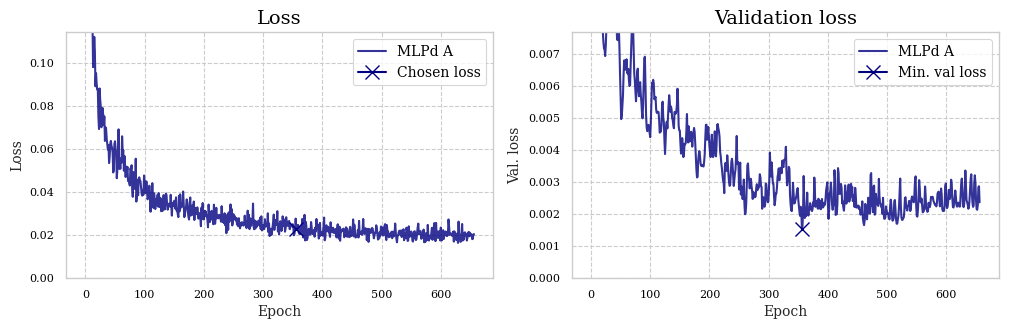

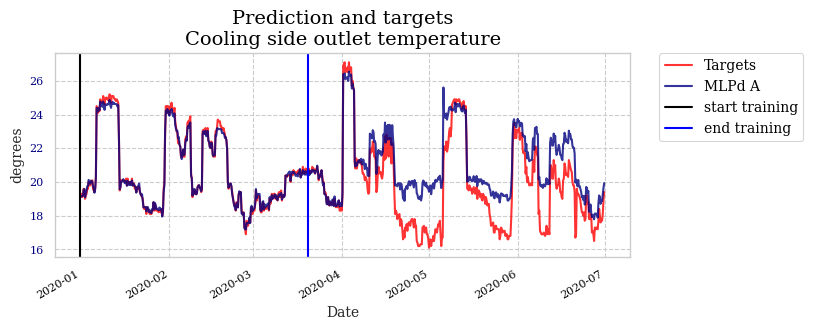

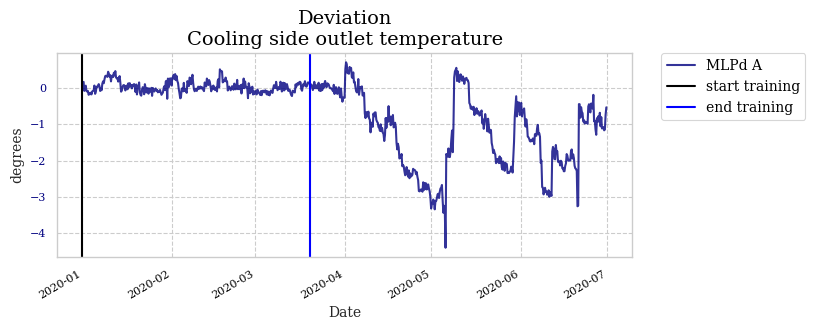

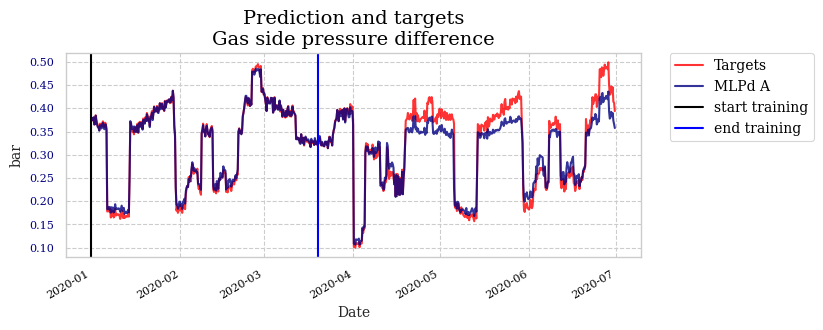

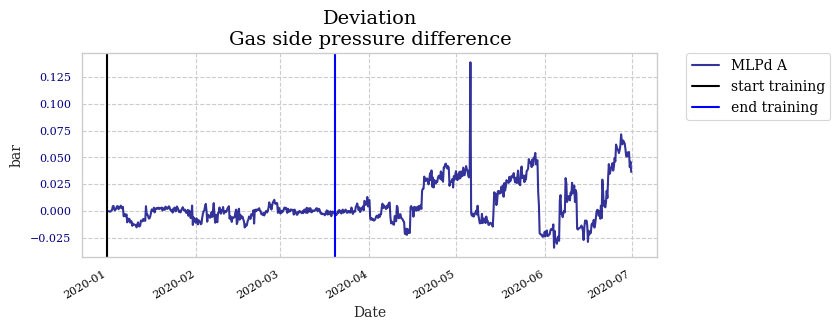

Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50TT002 - Cooling side outlet temperature
Col. 6 : 50TV001 - Cooling side valve opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 

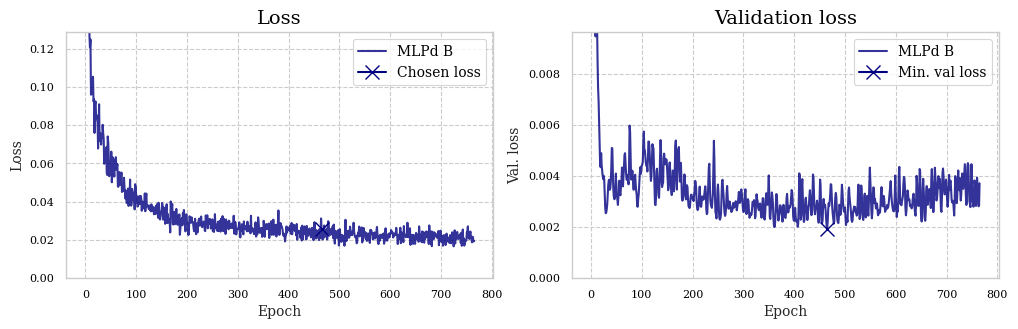

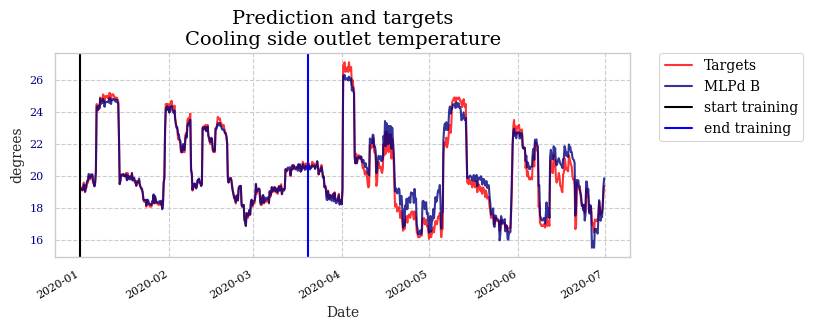

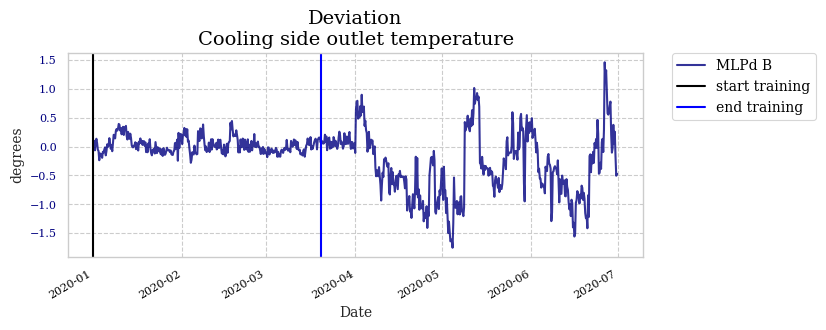

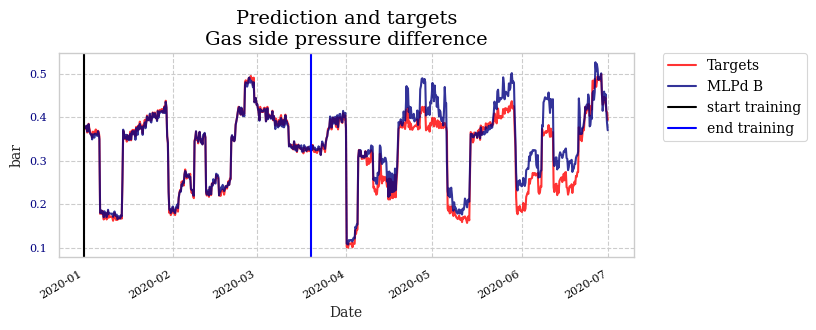

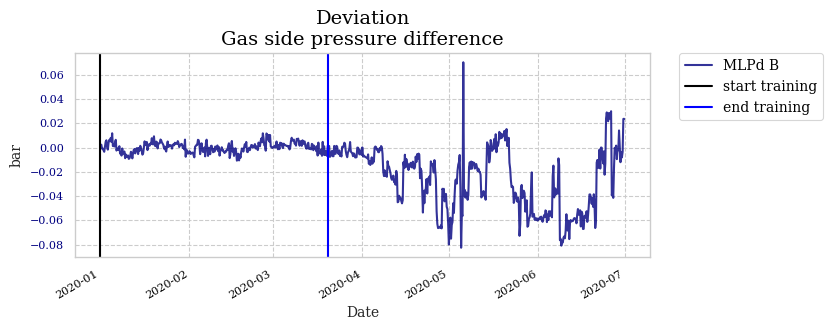

Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50FT001 - Cooling side flow
Col. 6 : 50TT002 - Cooling side outlet temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-

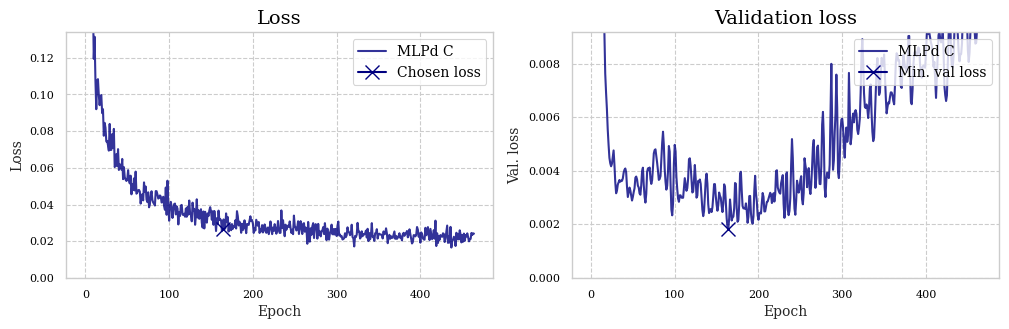

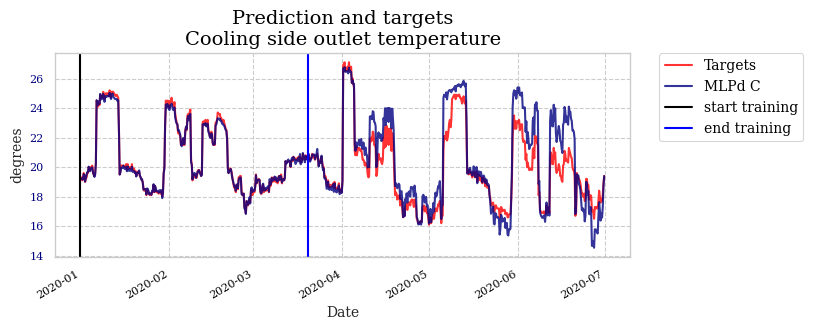

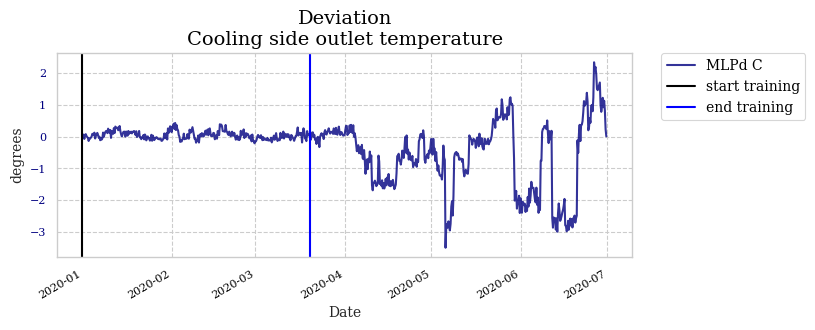

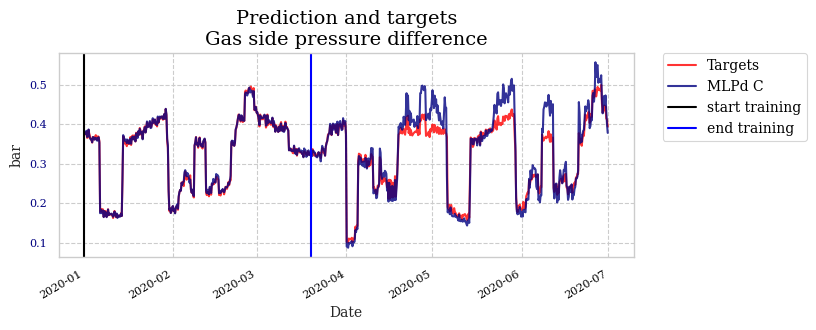

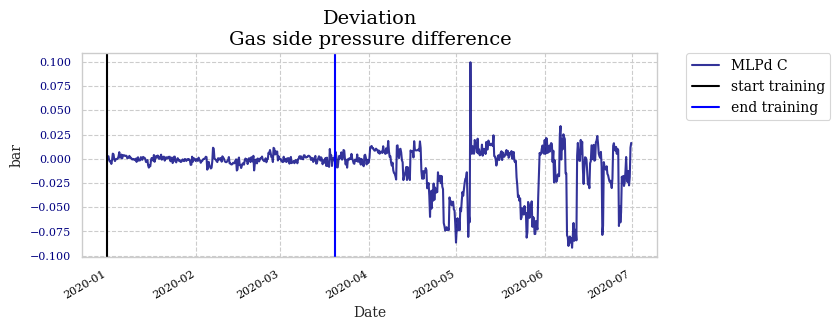

Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50PT001 - Cooling side inlet pressure
Col. 6 : 50TT002 - Cooling side outlet temperature
Col. 7 : 50TV001 - Cooling side valve opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 

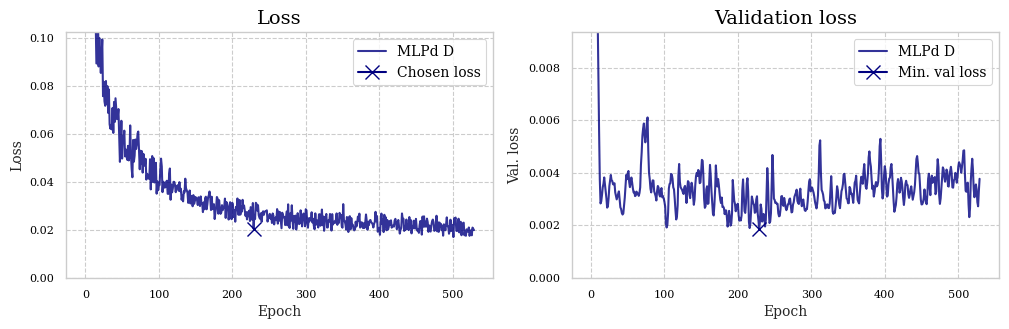

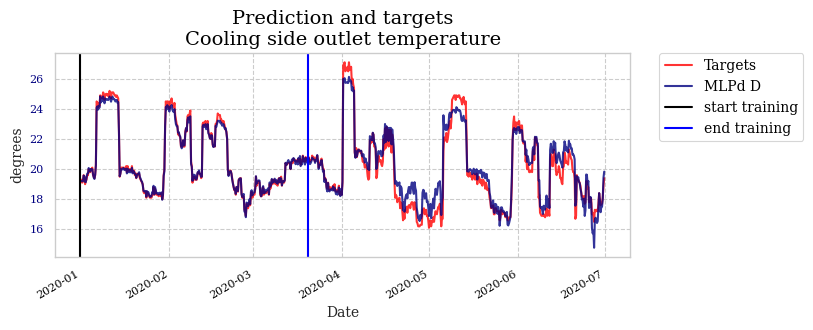

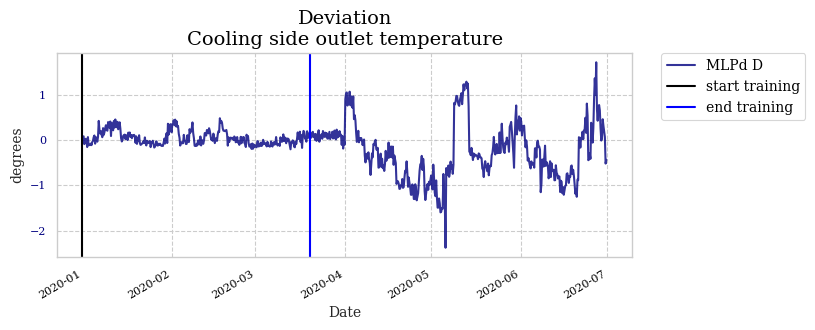

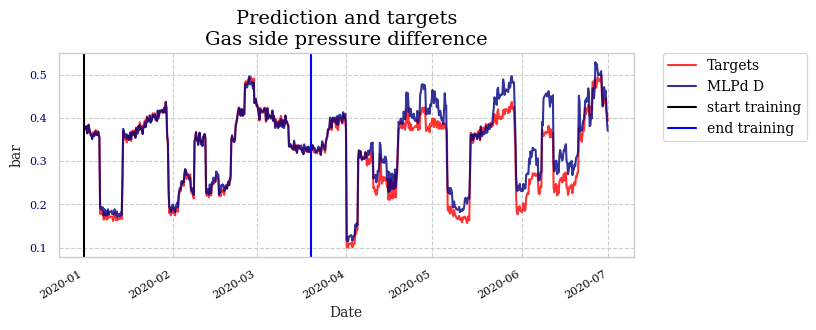

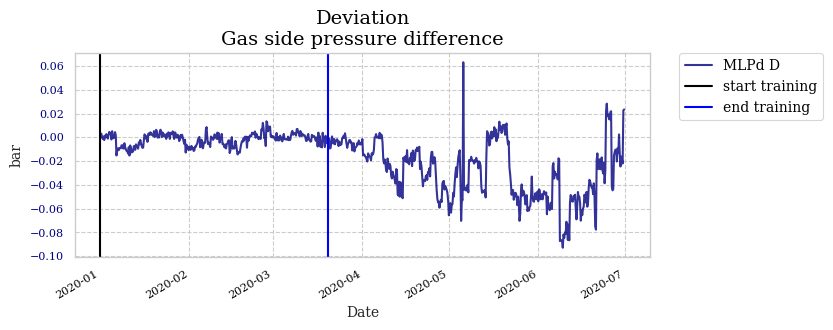

Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50PT001 - Cooling side inlet pressure
Col. 6 : 50FT001 - Cooling side flow
Col. 7 : 50TT002 - Cooling side outlet temperature
Col. 8 : 50TV001 - Cooling side valve opening

Finding data between 2020-01-01 00:00:

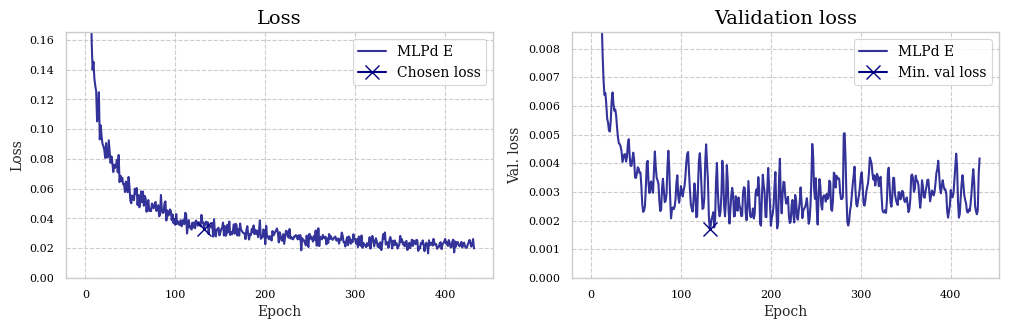

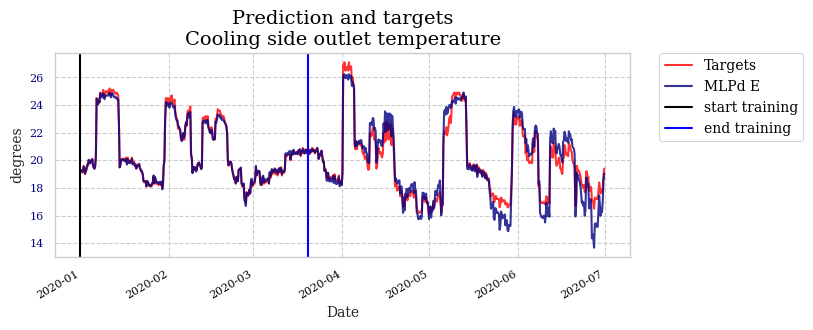

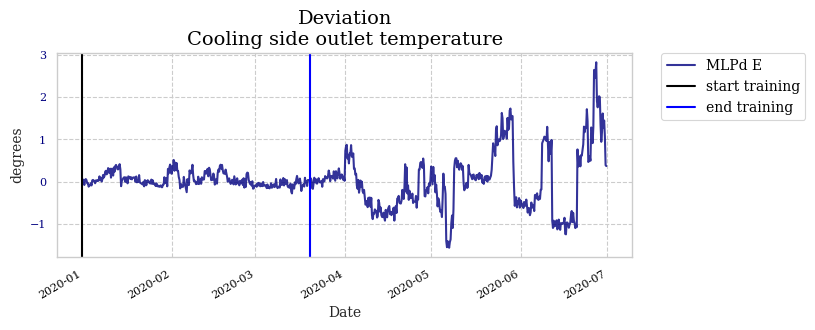

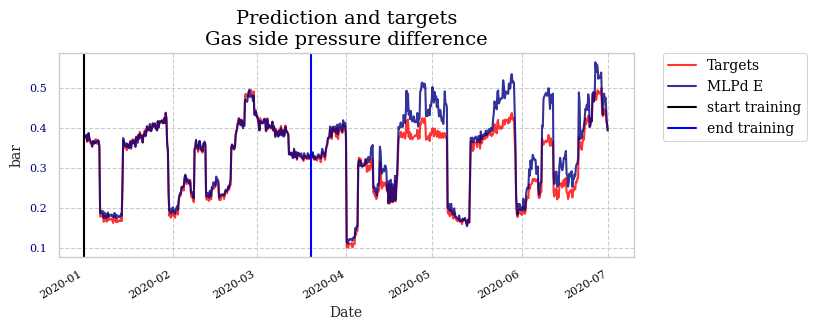

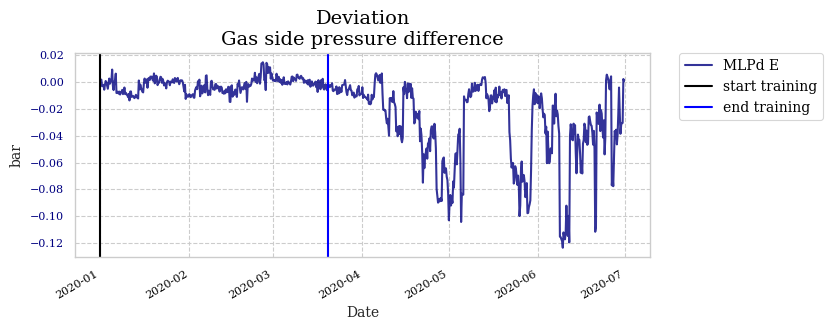

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.9955   |   0.8513   |
| MLPd B |    0.9969   |   0.932    |
| MLPd C |    0.9973   |   0.8866   |
| MLPd D |    0.9954   |   0.9284   |
| MLPd E |    0.9954   |   0.9003   |
+--------+-------------+------------+


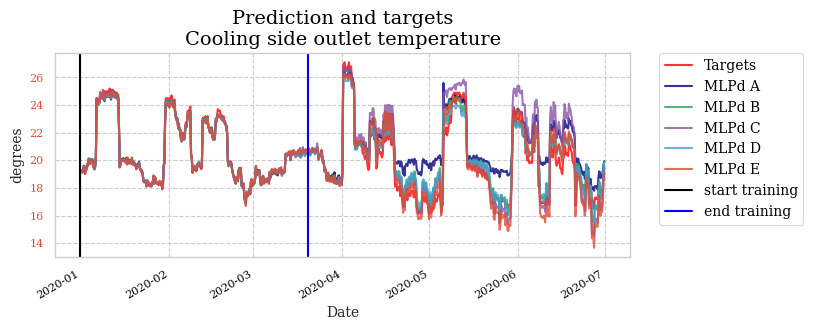

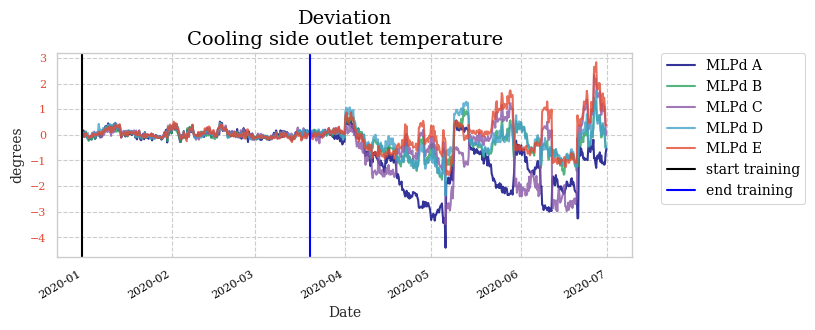

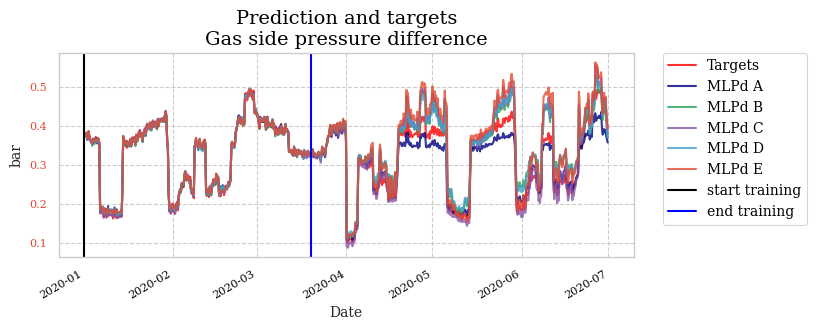

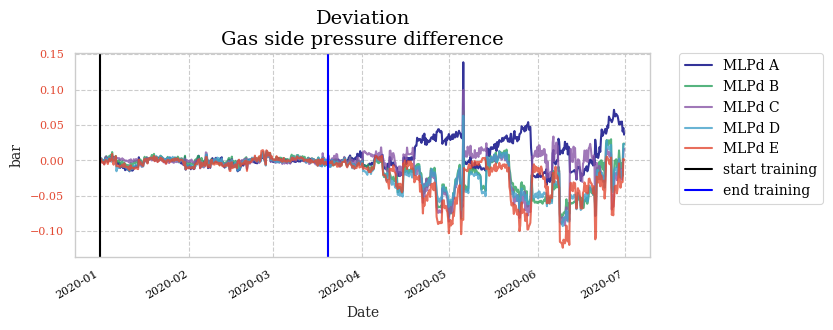

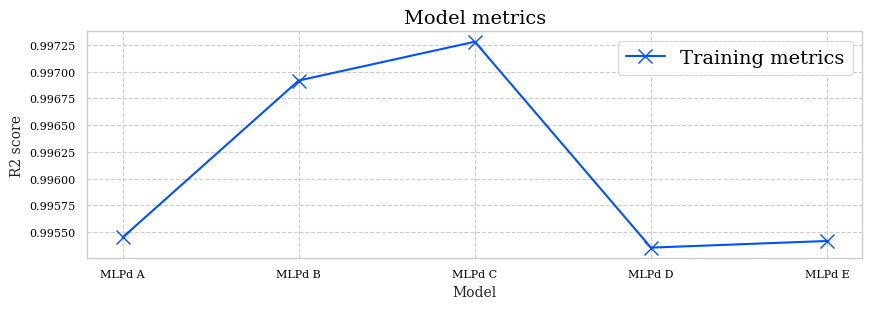

In [4]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 2)

# Some notes
- LSTM models do not work for data sets with limited amount of samples
- MLPs show the same as was seen for the regularization comparison, that there is some deviation (perhaps explained by overfitting) that cannot be easily explained hindering the models from fitting to the linear increase in fouling
- It is encouraging (at least for the reduced feature scheme...) that the error of the MLP does NOT seem to drop significantly with a reduced number of input parameters.
- Linear models work great in this example, even with a reduced number of input parameters

### Configurations dataset F

In [5]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('F', None, '30min')
targetColumns = [
	'TT0653_MA_Y'
]
irrelevantColumnsList = [
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
		'TIC0105_CA_Y',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
	],
]

### Predictions dataset F

Columns before removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0102_MA_Y - Varm side A temperatur inn
Col. 2 : TIC0101_CA_YX - Varm side A temperatur ut
Col. 3 : TT0104_MA_Y - Varm side B temperatur inn
Col. 4 : TIC0103_CA_YX - Varm side B temperatur ut
Col. 5 : TT0106_MA_Y - Varm side C temperatur inn
Col. 6 : TIC0105_CA_YX - Varm side C temperatur ut
Col. 7 : PDT0108_MA_Y - Varm side A trykkfall
Col. 8 : PDT0119_MA_Y - Varm side B trykkfall
Col. 9 : PDT0118_MA_Y - Varm side C trykkfall
Col. 10 : PIC0104_CA_YX - Innløpsseparator trykk
Col. 11 : TIC0425_CA_YX - Kald side temperatur inn
Col. 12 : TT0651_MA_Y - Kald side A temperatur ut
Col. 13 : TT0652_MA_Y - Kald side B temperatur ut
Col. 14 : TT0653_MA_Y - Kald side C temperatur ut
Col. 15 : TIC0101_CA_Y - Kald side A ventilåpning
Col. 16 : TIC0103_CA_Y - Kald side B ventilåpning
Col. 17 : TIC0105_CA_Y - Kald side C ventilåpning

Columns after removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0106_MA_Y - Varm side C te

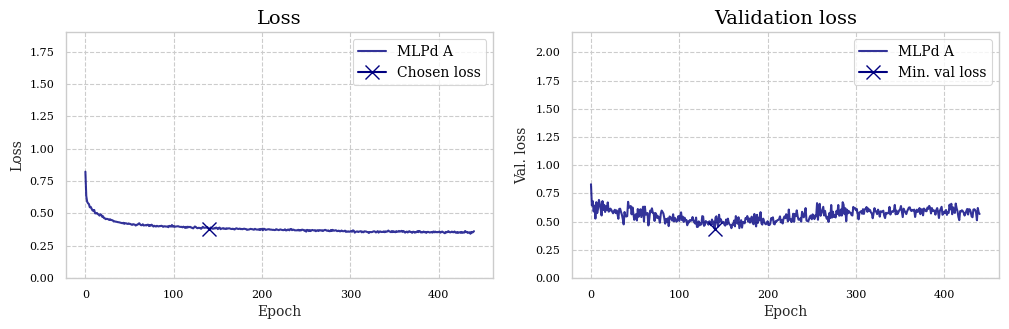

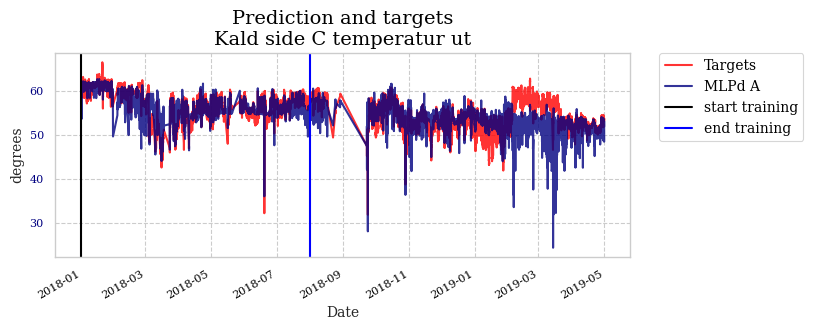

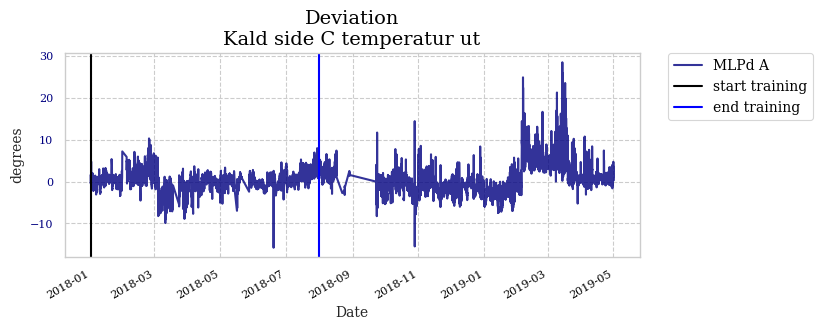

Columns before removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0102_MA_Y - Varm side A temperatur inn
Col. 2 : TIC0101_CA_YX - Varm side A temperatur ut
Col. 3 : TT0104_MA_Y - Varm side B temperatur inn
Col. 4 : TIC0103_CA_YX - Varm side B temperatur ut
Col. 5 : TT0106_MA_Y - Varm side C temperatur inn
Col. 6 : TIC0105_CA_YX - Varm side C temperatur ut
Col. 7 : PDT0108_MA_Y - Varm side A trykkfall
Col. 8 : PDT0119_MA_Y - Varm side B trykkfall
Col. 9 : PDT0118_MA_Y - Varm side C trykkfall
Col. 10 : PIC0104_CA_YX - Innløpsseparator trykk
Col. 11 : TIC0425_CA_YX - Kald side temperatur inn
Col. 12 : TT0651_MA_Y - Kald side A temperatur ut
Col. 13 : TT0652_MA_Y - Kald side B temperatur ut
Col. 14 : TT0653_MA_Y - Kald side C temperatur ut
Col. 15 : TIC0101_CA_Y - Kald side A ventilåpning
Col. 16 : TIC0103_CA_Y - Kald side B ventilåpning
Col. 17 : TIC0105_CA_Y - Kald side C ventilåpning

Columns after removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0106_MA_Y - Varm side C te

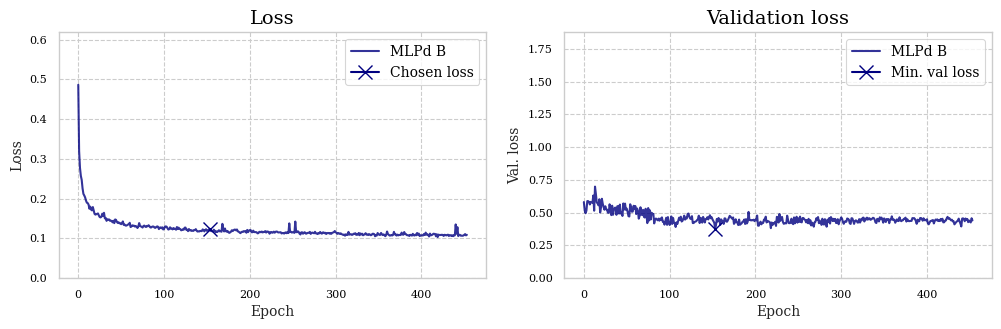

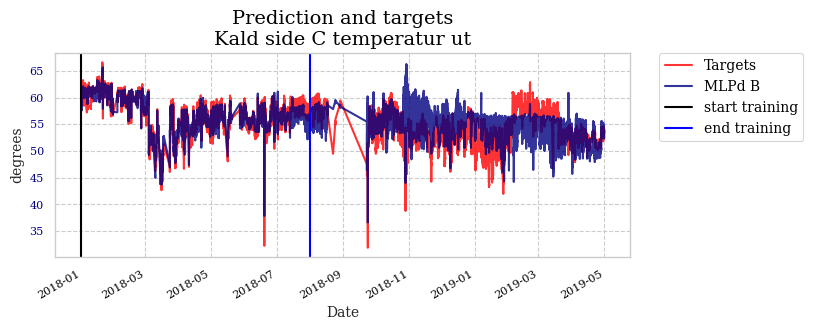

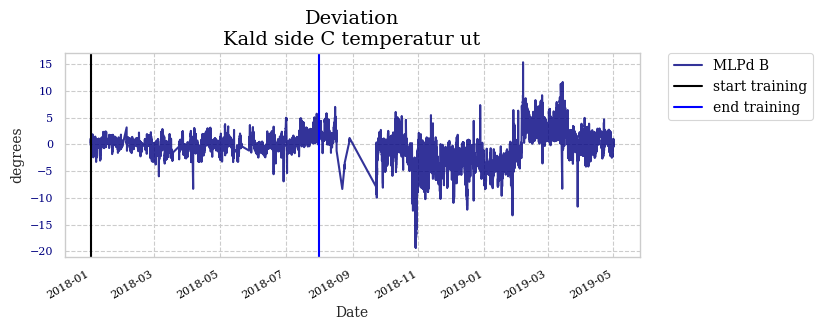

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.6278   |   0.3007   |
| MLPd B |    0.8474   |   0.3934   |
+--------+-------------+------------+


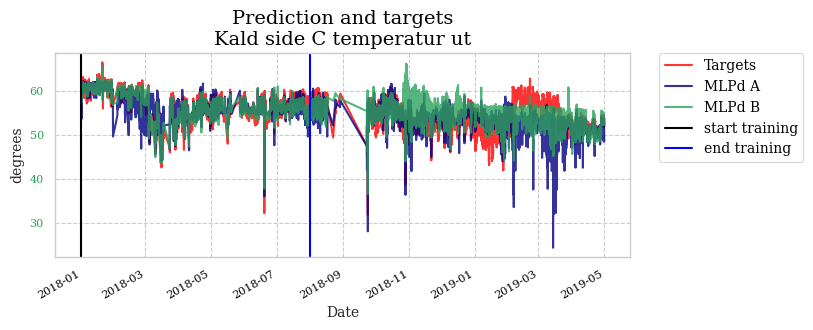

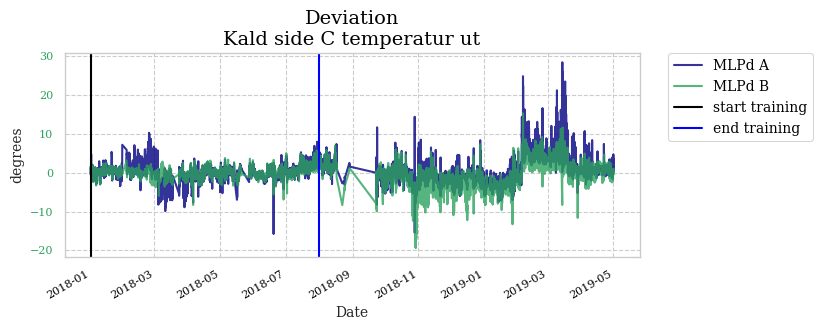

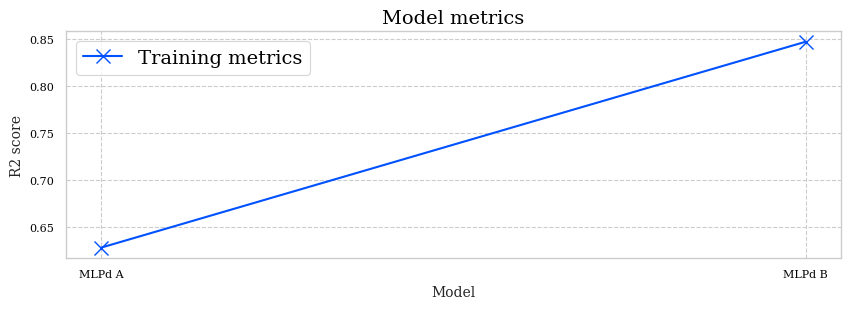

In [6]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)

### Configurations dataset G

In [7]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', None, '30min')
targetColumns = [
    'TT0026',
	'PDI0064',
]
irrelevantColumnsList = [
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in 
	[
		'PDT0024',
		'FI0027',
		'TIC0022U',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C valve
	[
		'PDT0024',
		'FI0027',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C flow
	[
		'PDT0024',
		'TIC0022U',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'PDT0024',
		'FI0027',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'PDT0024',
	],
]

### Predictions dataset G

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd A was loaded from file
+--------+-----------+-------------+---------------+------

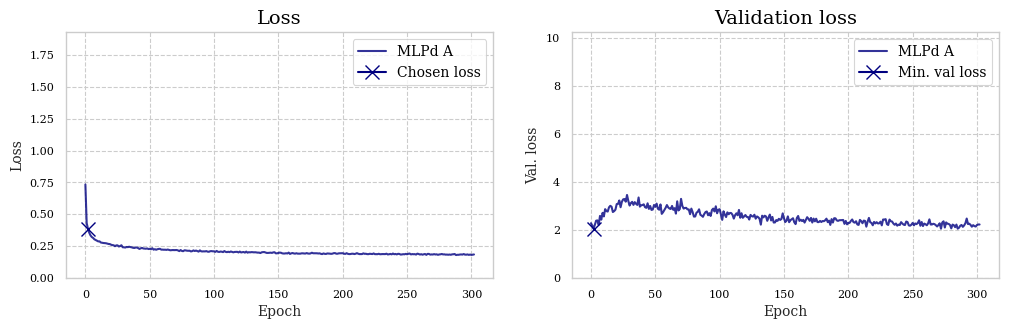

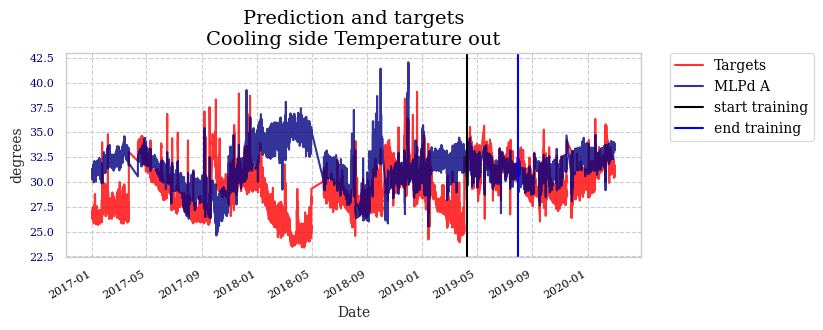

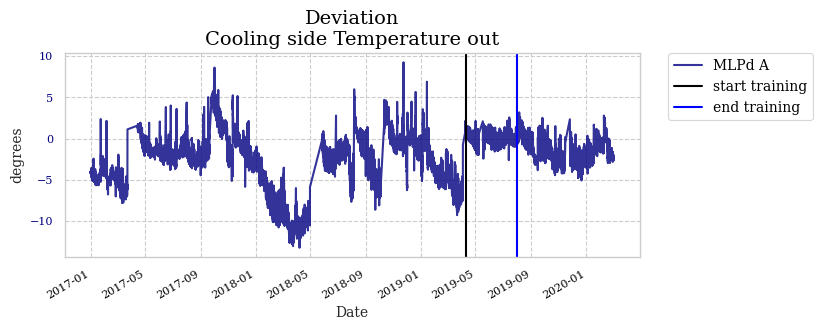

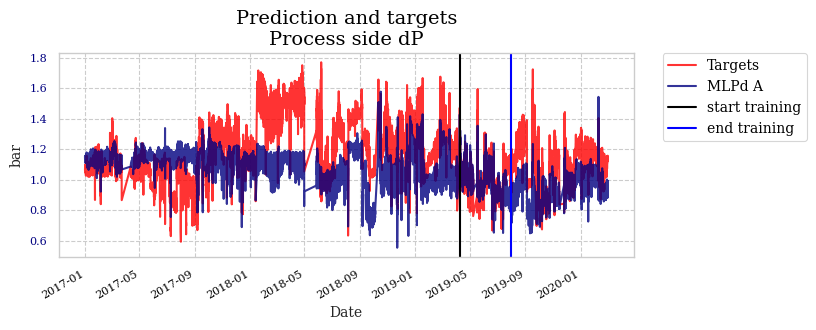

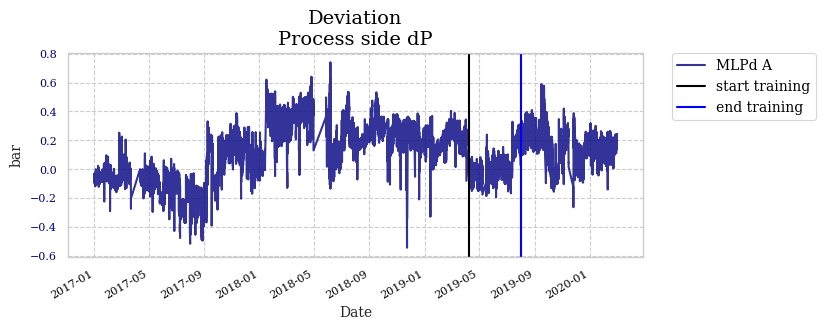

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : TIC0022U - Cooling side valve opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd B was loaded from file
+--------+-

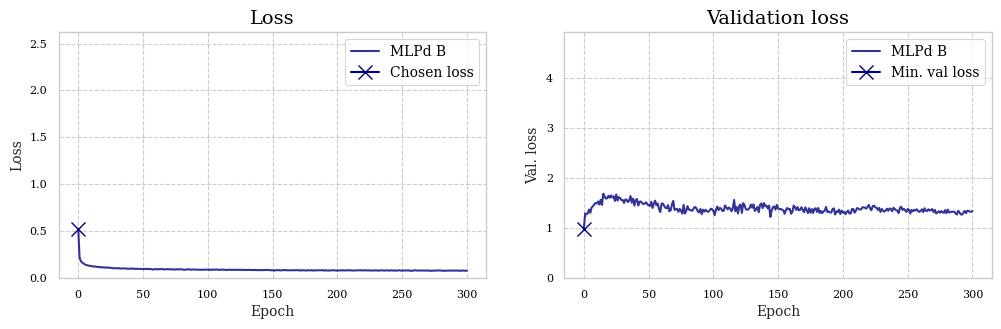

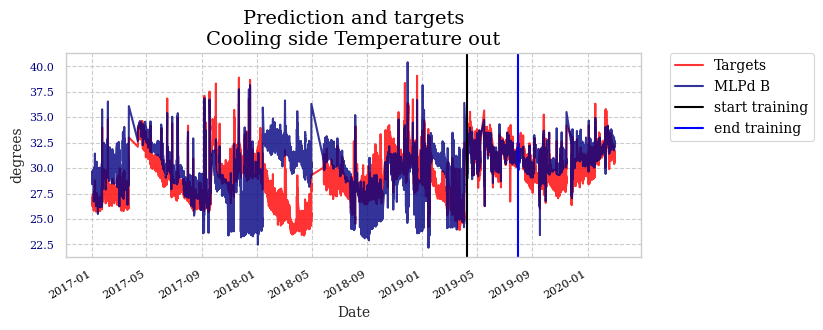

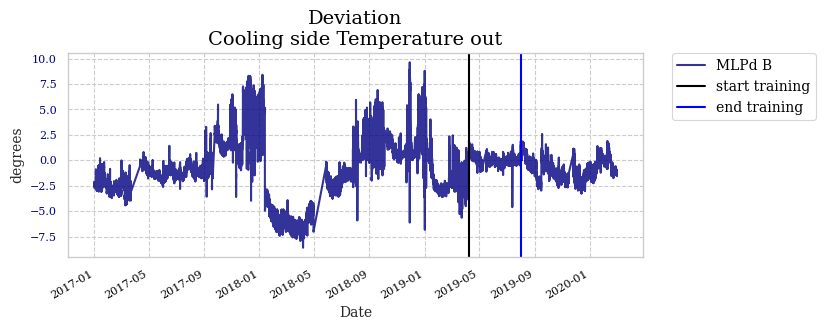

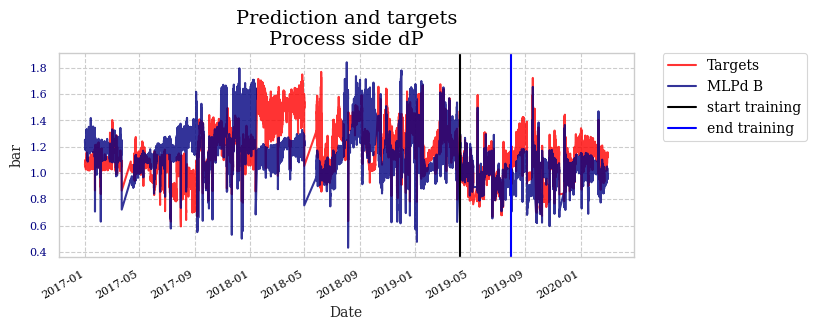

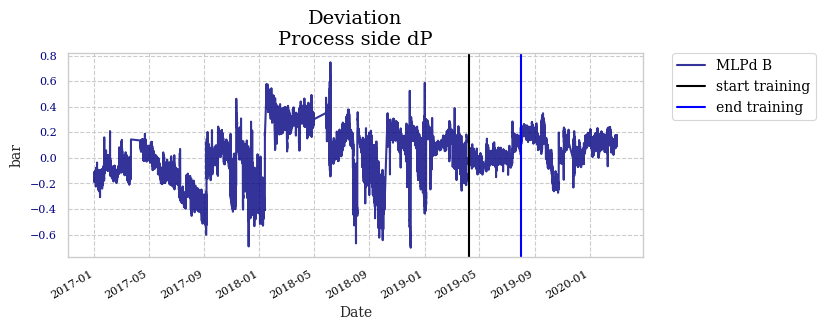

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : FI0027 - Cooling side flow rate

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd C was loaded from file
+--------+-------

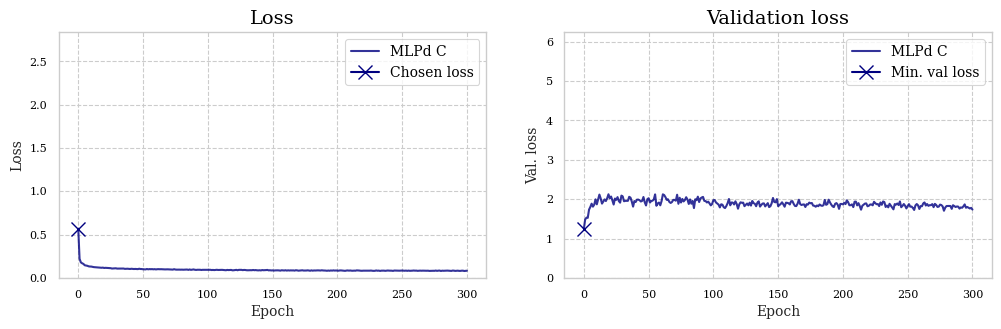

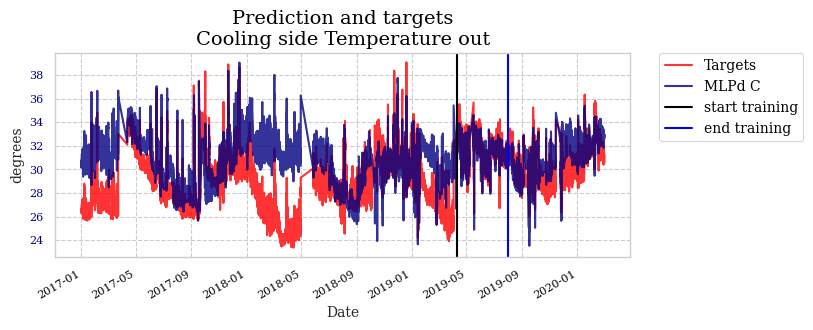

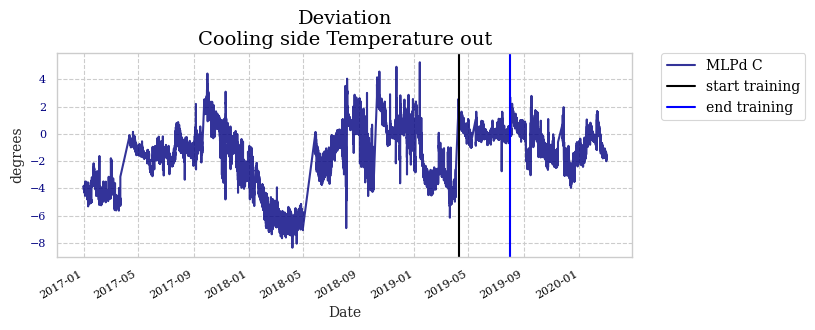

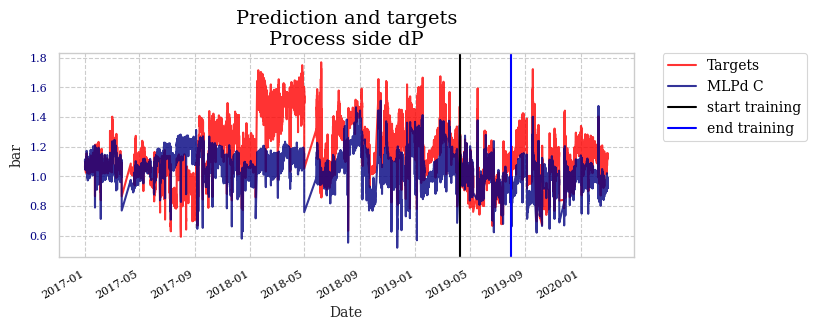

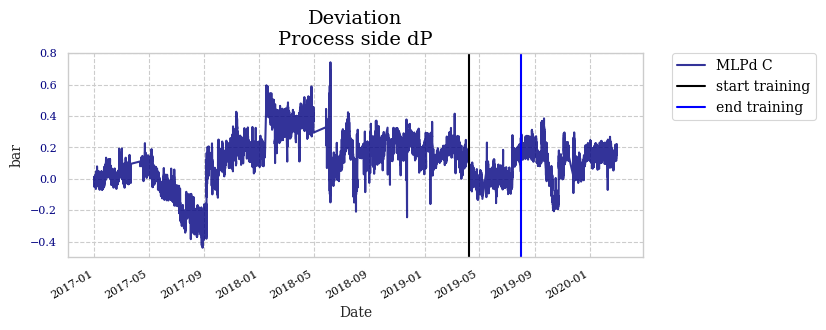

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : TIC0022U - Cooling side valve opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Mo

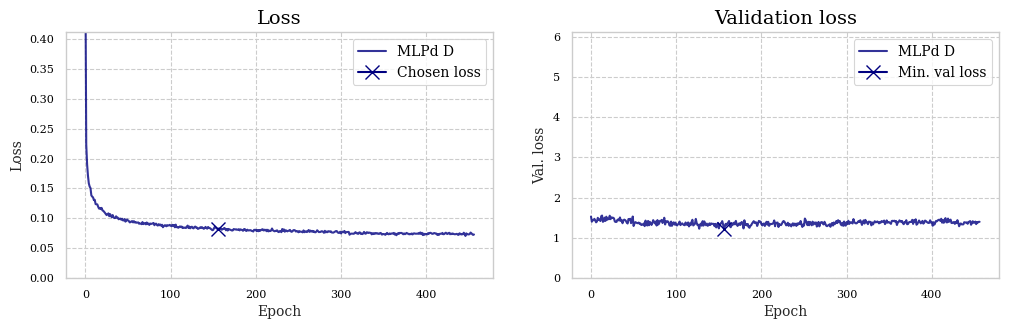

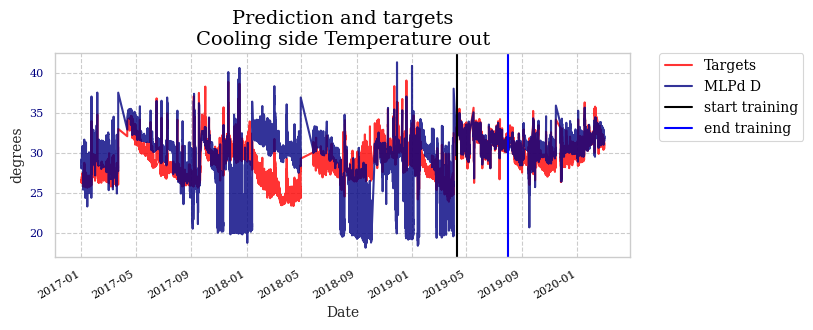

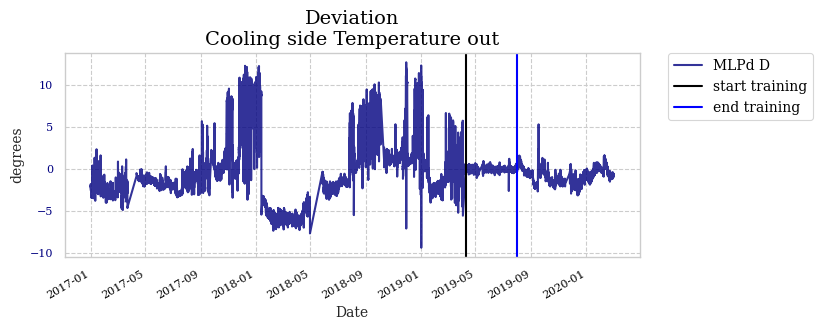

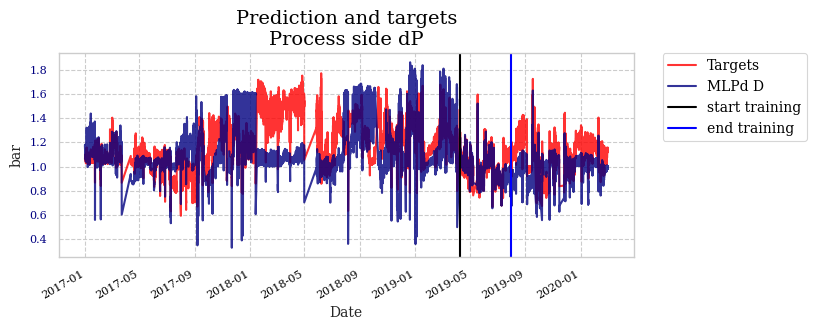

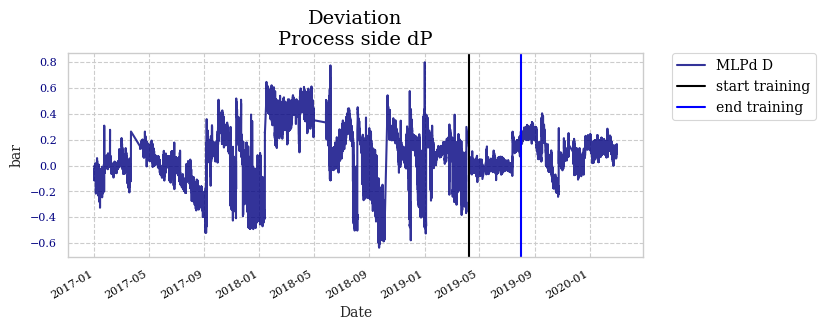

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and

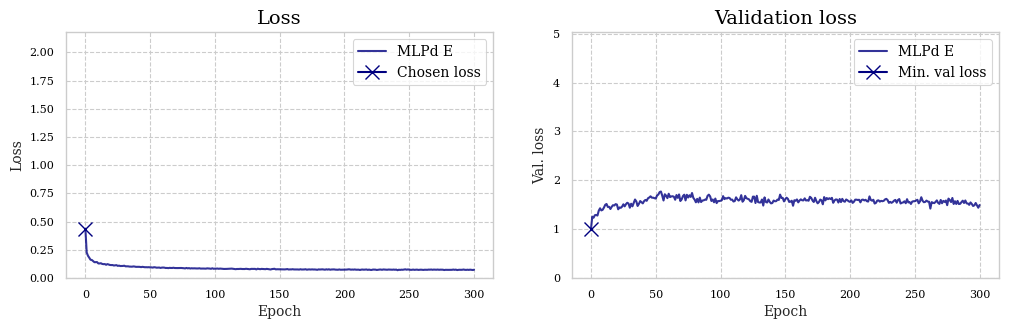

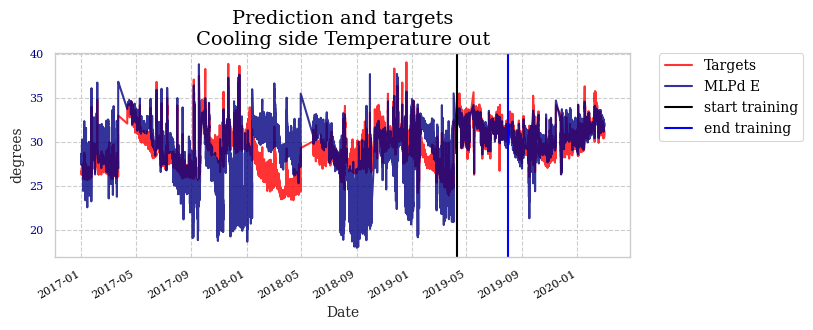

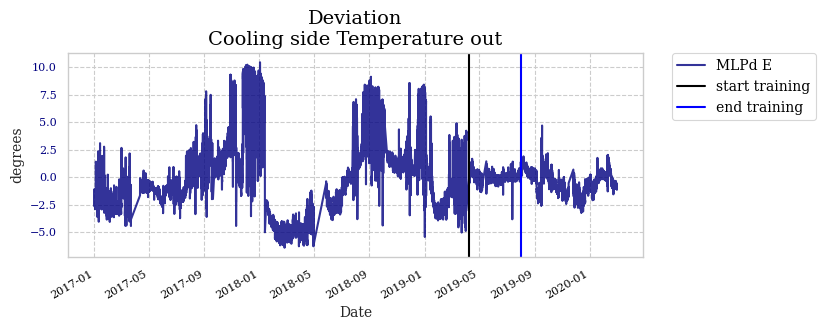

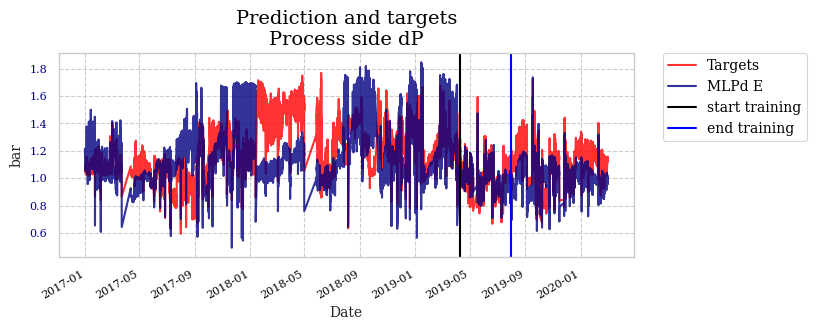

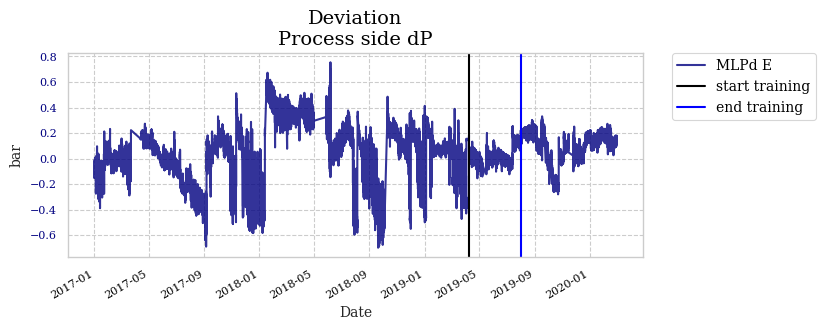

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.3504   |  -1.2369   |
| MLPd B |    0.6746   |  -0.4656   |
| MLPd C |    0.6151   |  -0.3537   |
| MLPd D |    0.7107   |   -1.153   |
| MLPd E |    0.6665   |  -0.7593   |
+--------+-------------+------------+


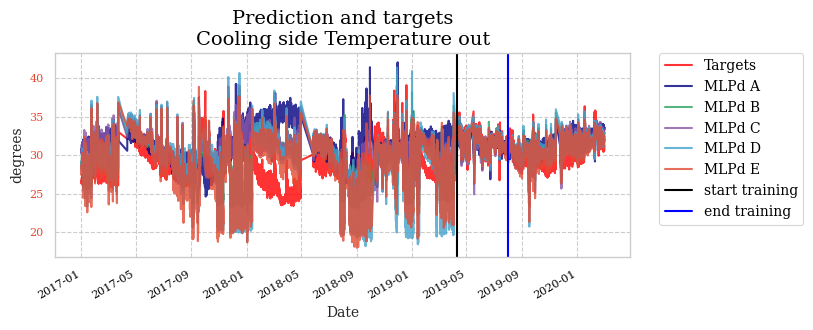

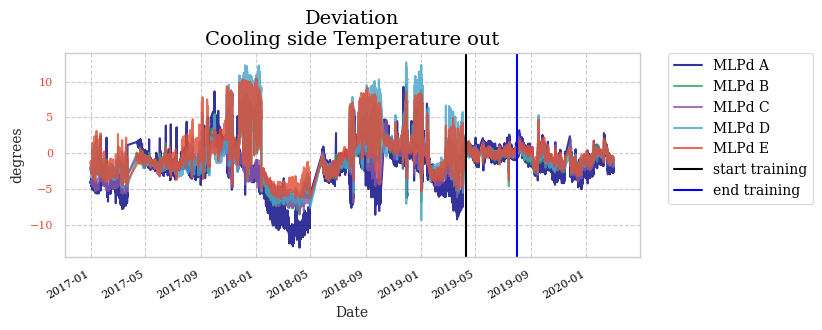

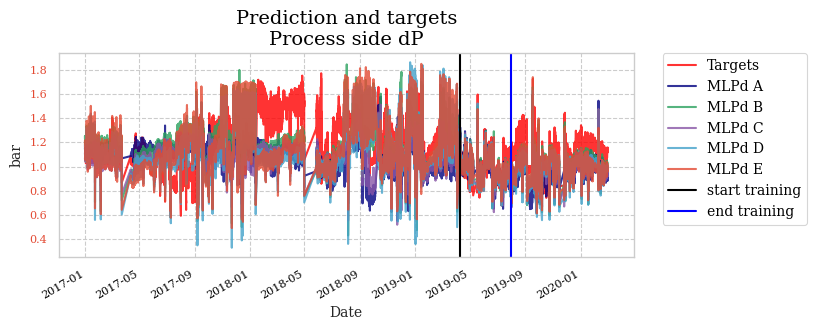

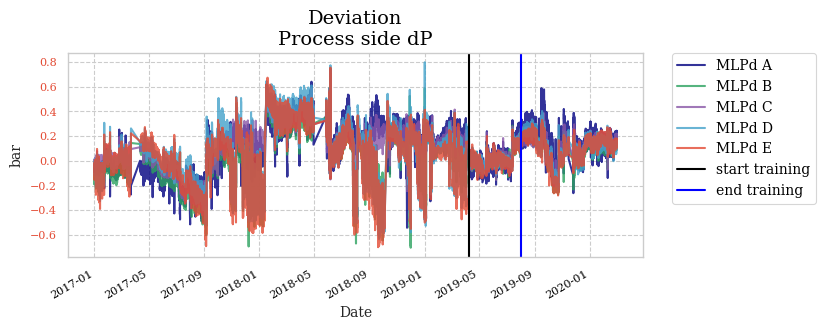

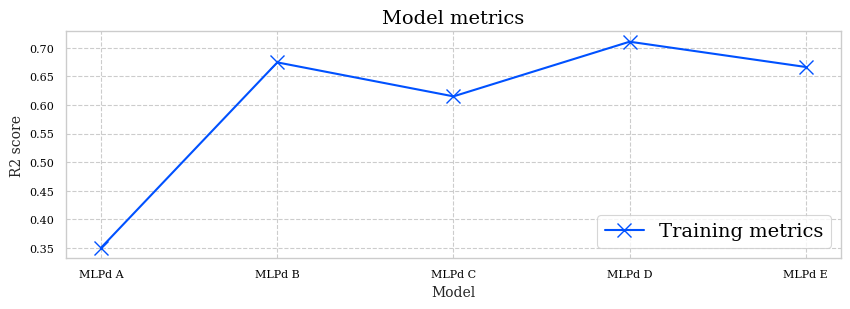

In [8]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)